In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [2]:
import librosa
from IPython.display import Audio
import time
import torchaudio
import torch

path = "../input/kaggle-pog-series-s01e02/train"
test_path = "../input/kaggle-pog-series-s01e02/test"

df = pd.read_csv(path+".csv")
test_df = pd.read_csv(test_path+".csv")

print(df.shape)
def load_data(path, df,savefile=False,visualize=False,test=False):
    df["file_exists"] = True
    data = list()
    directory = path
    print(path)
    transformer = torchaudio.transforms.MFCC( sample_rate=22050, n_mfcc=20,melkwargs={"n_fft": 512, "hop_length": 256})
    #transformer = torchaudio.transforms.MelSpectrogram(sample_rate=22050,n_fft=2048, hop_length=512,normalized =True)
    #powertodb = torchaudio.transforms.AmplitudeToDB()
    #display(df)
    #w_rate, w_data = read(path + "/_background_noise_/white_noise.wav")
    size = 32000
    duration = 10
    for i,item in enumerate(df.itertuples()):
        try:
            f = item.filename
            file = path+"/"+str(f)
            
            r_data, samplingrate = librosa.load(path+"/"+f, duration=duration)
            logmel = librosa.feature.mfcc(y=r_data, n_fft=1024, hop_length=256, n_mels=80,n_mfcc=20)
            #logmel = librosa.power_to_db(logmel, ref=np.max)
            logmel = librosa.util.normalize(logmel)
            #x_test = librosa.util.normalize(x_test)
            
            #r_data, samplingrate = torchaudio.load(path+"/"+f)
            #r_data = torch.mean(r_data, dim=0).unsqueeze(0)
            #logmel = transformer(r_data[:20000])#.flatten()[:size])  
            
            size=r_data.shape[0]
            if visualize:
                if i%5==1:
                    r_data1,_ = librosa.effects.trim(r_data,top_db=5)
                    print(r_data1.shape,r_data.shape)
                    plt.plot(range(len(r_data)),r_data)
                    plt.show()
                    plt.pcolormesh(logmel)
                    plt.colorbar()
                    plt.show()
                    display(Audio(r_data, rate=samplingrate))
                    display(Audio(r_data1, rate=samplingrate))
                          
            if not test:
                genre = item.genre
            else:
                genre = -1
                
            data.append({
                "filename": f,
                #"samplingrate": samplingrate,
                "genre": genre,
                #"samples": narray,
                "mfcc": logmel
                #"lmfcc": lmfcc
            })
            if i%1000 == 999:
                print(i, genre)
                
        except FileNotFoundError:
            print("FileNotFoundError" + item.filename)
            df.loc[df.filename == item.filename, 'file_exists'] = False
            continue
        except RuntimeError:
            print("FileNotFoundError" + item.filename)
            df.loc[df.filename == item.filename, 'file_exists'] = False
            continue
        except ValueError:
            print("[ValueError] Could not save:" + item.filename)
            continue

    if savefile:
        np.savez('melspectrograms.npz', data=data)

    return data
"""start = time.perf_counter()
data = load_data(path,savefile=True)
end = time.perf_counter()
print((end-start)/60)"""

(19922, 5)


'start = time.perf_counter()\ndata = load_data(path,savefile=True)\nend = time.perf_counter()\nprint((end-start)/60)'

In [3]:
import os.path
import numpy as np
#exists = os.path.exists('dataset/TTS-lmfcc.npz')
load = True
data = None
test_data = None
start = time.perf_counter()
if load:
    print("reading files...")
    data = np.load('../input/melspectrograms-train-test/melspectrograms.npz', allow_pickle=True)['data']
    test_data = np.load('../input/melspectrograms-train-test/melspectrograms_test.npz', allow_pickle=True)['data']

    print("lmfcc's loaded!")
else:
    print("Loading data from wav files...")
    #data = load_data(path,df,savefile=False)
    test_data = load_data(test_path,test_df, savefile=False,test=True)
    np.savez('melspectrograms_test.npz', data=test_data)
    #np.savez('melspectrograms.npz', data=data)

    print("lmfcc data saved to: dataset/TTS-lmfcc.npz")
end = time.perf_counter()
print(end-start)

reading files...
lmfcc's loaded!
15.310237613000027


In [4]:
from sys import getsizeof

print(getsizeof(data))
x_train, y_train = [], []
x_test = []
shape = data[0]['mfcc'].T.shape
#x_train = np.zeros((len(data),data[0]['mfcc'].shape[1],data[0]['mfcc'].shape[0]))
z_train = []
z_test = []
for i,d in enumerate(data):
    if d['mfcc'].T.shape == shape:
        x_train.append(d['mfcc'].T)
        z_train.append(d['filename'])
        y_train.append(df.loc[d['genre']==df.genre]['genre_id'].values[0])
        
        
for i,d in enumerate(test_data):
    if d['mfcc'].T.shape == shape:
        x_test.append(d['mfcc'].T)
        z_test.append(d['filename'])
        
x_train = np.array(x_train)
x_test = np.array(x_test)

print(x_train.shape)
print(x_test.shape)


159376
(19904, 862, 20)
(5076, 862, 20)


In [5]:
# Imports:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras as keras
# TODO: do we need maxpooling2D and Upsampling2D?
from tensorflow.keras.layers import Input, Dense, Conv1D,Conv2DTranspose,Conv2D, MaxPooling2D, UpSampling2D, Flatten, GlobalAveragePooling2D,Dense, Reshape, Lambda,BatchNormalization,ReLU,MaxPool2D,Dropout,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC

1.0
-1.0
(19904, 862, 20)


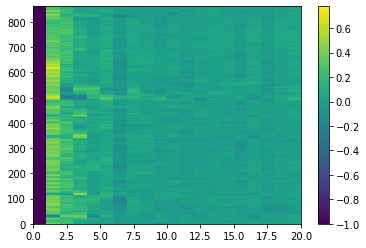

1.0
-1.0


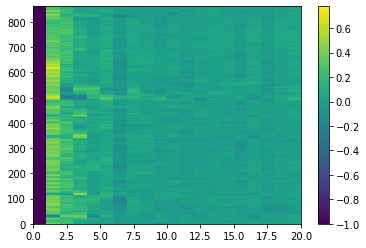

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
print(np.max(x_train))
print(np.min(x_train))
print(x_train.shape)
plt.pcolormesh(x_train[0])
plt.colorbar()

plt.show()
"""x_train/=80
x_train*=-1
x_test/=80
x_test*=-1"""
#scaler = MinMaxScaler()
#x_train = librosa.util.normalize(x_train)
#x_test = librosa.util.normalize(x_test)

print(np.max(x_train))
print(np.min(x_train))
plt.pcolormesh(x_train[0])
plt.colorbar()


In [7]:
oh_encoder = OneHotEncoder(categories='auto', sparse=False)
y_train_oh = oh_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
print(np.count_nonzero(y_train_oh,axis=0))
print(np.unique(y_train, return_counts=True))

# Parameters:
n_batch = 256
n_classes = y_train_oh.shape[1]
n_latent = 25
n_channels = 1
n_epoch = 50

[3071 3095 2582 1800 1752 1214 1181 1044  945  814  796  495  408  306
  142   94   94   58   13]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18]), array([3071, 3095, 2582, 1800, 1752, 1214, 1181, 1044,  945,  814,  796,
        495,  408,  306,  142,   94,   94,   58,   13]))


Source: https://www.kaggle.com/ashishpatel26/best-trick-for-audio-data

In [8]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50

# load model
x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(-1, x_test.shape[1], x_test.shape[2], 1)

input_sound = Input(shape=x_train.shape[1:])
input_cond = Input(shape=(n_classes,))
kernel_size = 3
stride_size = (2,2)
filters = 32
learning_rate = 0.01


def get_2d_conv_model(n_epoch=50,LR=2e-3):
    
    nclass = n_classes
    
    inp = Input(shape=x_train.shape[1:])
    x = Conv2D(16, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)

    
    x = Conv2D(64, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(64)(x)
    x = ReLU()(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    opt = Adam(LR)

    model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=[AUC()])
    return model

def get_resnet(n_epoch=50,LR=1e-1):
    input_tensor = Input(shape=x_train.shape[1:])
    x = Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
    baseModel = ResNet50(weights=None,
                         include_top=False,
                         input_shape=(x_train.shape[1],x_train.shape[2],3))
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel(x,training=True)
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(n_classes, activation="softmax")(headModel)
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=input_tensor, outputs=headModel)
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the training process
    for layer in baseModel.layers:
        layer.trainable = False
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        LR,
        decay_steps=100000,
        decay_rate=0.92,
        staircase=True)
    opt = SGD(lr_schedule,momentum=0.96)
    model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=[AUC()])
    return model

In [9]:
from keras.callbacks import History 
n_epoch = 200
n_batch = 16

model = get_2d_conv_model(n_epoch)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 862, 20, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 862, 20, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 862, 20, 16)       64        
_________________________________________________________________
re_lu (ReLU)                 (None, 862, 20, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 862, 20, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 862, 20, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 862, 20, 32)       128   

2022-03-31 21:40:45.437430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 21:40:45.438523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 21:40:45.439261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 21:40:45.440482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
history =  model.fit(x_train, y_train_oh,shuffle=True, epochs=n_epoch,batch_size=n_batch, callbacks=[EarlyStopping(patience=10)])

2022-03-31 21:40:50.641104: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1372579840 exceeds 10% of free system memory.
2022-03-31 21:40:52.047232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1372579840 exceeds 10% of free system memory.
2022-03-31 21:40:53.047484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-03-31 21:40:54.816474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1244/1244 [==============================] - 60s 42ms/step - loss: 2.0956 - auc: 0.8572
Epoch 2/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.9561 - auc: 0.8783
Epoch 3/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.8857 - auc: 0.8875
Epoch 4/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.8336 - auc: 0.8941
Epoch 5/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.7992 - auc: 0.8983
Epoch 6/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.7692 - auc: 0.9019
Epoch 7/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.7387 - auc: 0.9055
Epoch 8/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.7147 - auc: 0.9081
Epoch 9/200
1244/1244 [==============================] - 53s 42ms/step - loss: 1.6982 - auc: 0.9103
Epoch 10/200
1244/1244 [==============================] - 52s 42ms/step - loss: 1.6755 - auc: 0.9131
Epoch 11/20

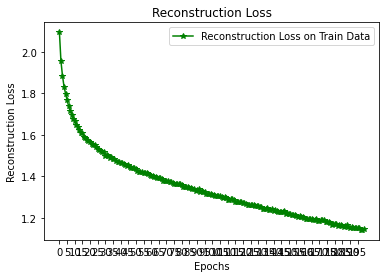

In [11]:
plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
#plt.plot(np.arange(0,epochs),history.history['val_loss'],label="Reconstruction Loss on Validation Data", marker='^',color='red')
plt.plot(np.arange(0,epochs),history.history['loss'],label="Reconstruction Loss on Train Data", marker='*',color='green')

plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

2022-04-01 00:39:44.490943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 350040960 exceeds 10% of free system memory.
2022-04-01 00:39:44.864942: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 350040960 exceeds 10% of free system memory.


,genre_id,song_id
0,3,7072
1,12,10207
2,3,20008
3,6,10924
4,1,21896
...,...,...
5073,3,6427
5074,0,16903
5075,3,1731
5076,9,12871


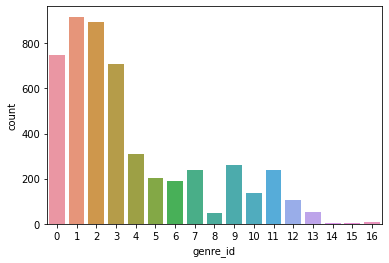

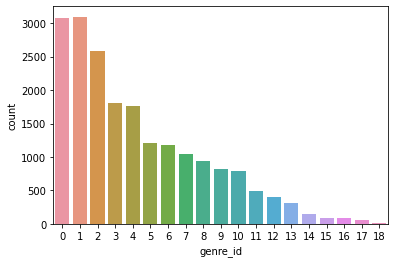

In [12]:
import seaborn as sns


y_pred = model.predict(x_test)
subm = []
temp_subm = []
for idx, i in enumerate(test_df.itertuples()):
    temp_subm.append([0,i.song_id])
    #print(test_df.loc[test_df.filename == z_test[i]].song_id.values[0])
results_df = pd.DataFrame(temp_subm, columns=['genre_id','song_id'])

for i,_ in enumerate(z_test):
    #print(test_df.loc[test_df.filename == z_test[i]].song_id.values[0])
    results_df.loc[test_df.loc[test_df.filename == z_test[i]].song_id.values[0]==results_df.song_id,'genre_id'] = np.argmax(y_pred[i])
    
display(results_df)
ax = sns.countplot(x = results_df['genre_id'])
plt.show()
ax = sns.countplot(x = df['genre_id'])
plt.show()
results_df.to_csv("submission.csv", index=False)

In [13]:
#1.3934 